# Homework 4
## Part 1.1
Gala is installed! Thanks conda!

## Part 1.2 
_Establish the 6-D coordinates of your cluster_  I chose the the double cluster, so I'm going to import this stuff from Simbad. Simbad has everything, and the values look pretty believable from HW2. For the most part going to just use the average of both NGC 869 and NGC 884 for parameters going forward.

In [1]:
from astroquery.simbad import Simbad
import astropy.units as u
import numpy as np

customSimbad = Simbad()
customSimbad.get_field_description('distance')
customSimbad.remove_votable_fields('coordinates')
customSimbad.add_votable_fields('velocity','pm','distance')
customSimbad.add_votable_fields('ra(d;A;ICRS;;)', 'dec(d;D;ICRS;;)')
result_table = customSimbad.query_objects(["NGC869", "NGC884"])
result_table.keep_columns(['MAIN_ID', 'RVZ_RADVEL', 'PMRA', 'PMDEC', 'Distance_distance', 'RA_d_A_ICRS__', 'DEC_d_D_ICRS__'])
result_table.rename_column('MAIN_ID', 'ID')
result_table.rename_column('RA_d_A_ICRS__', 'RA')
result_table.rename_column('DEC_d_D_ICRS__', 'DEC')
result_table.rename_column('Distance_distance', 'DISTANCE')
result_table.rename_column('RVZ_RADVEL', 'RV')
print(result_table)

def double_cluster_val(name, units):
    return np.mean([result_table[0][name], result_table[1][name]]) * units


ra = double_cluster_val('RA', u.deg)
dec = double_cluster_val('DEC', u.deg)
dist = double_cluster_val('DISTANCE', u.pc).to(u.kpc)
pmra = double_cluster_val('PMRA', u.mas/u.yr)
pmdec = double_cluster_val('PMDEC', u.mas/u.yr)
rv = double_cluster_val('RV', u.km/u.s)

print("---------------------")
print(f"RA = {ra} DEC={dec} DIST={dist}")
print(f"PMRA = {pmra} PMDEC={pmdec} RV={rv}")

Measure of distances by several means
    ID       RV      PMRA     PMDEC    DISTANCE       RA         DEC     
           km / s  mas / yr  mas / yr                deg         deg     
--------- ------- --------- --------- ---------- ----------- ------------
NGC   869 -38.900    -0.694    -1.083  2197.0000 34.74100000  57.13400000
NGC   884 -43.525    -0.602    -1.062  1989.0000 35.58400000  57.14900000
---------------------
RA = 35.1625 deg DEC=57.1415 deg DIST=2.093 kpc
PMRA = -0.6482 mas / yr PMDEC=-1.0723500000000001 mas / yr RV=-41.2125 km / s


I'm also going to use my cluster membership criteria to query gaia, and get positions and velocities for everything that I can just so I have it for poking at the dynamics. Sadly only 26 of my member stars have radial velocities.

In [16]:
from astroquery.gaia import Gaia
import astropy.coordinates as coord

def query_gaia(field_size, simbad_result):    

    cluster_center = coord.SkyCoord(ra=np.mean(simbad_result['RA']), dec=np.mean(simbad_result['DEC']), unit=(u.degree, u.degree) , frame='icrs')

    Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"

    fields_of_interest = f"""--
    source_id, 
    ra, dec,             -- Sky Location
    r_med_geo,           -- Bailer-Jones distance
    pmra, pmdec,         -- Sky Proper motion
    radial_velocity,    -- Radial velocity
    astrometric_params_solved -- Filtering to make sure we get at least the 5 sky params above (bias introduced here)
    """


    query = f"""
    SELECT 
    --TOP 10
    {fields_of_interest}
    FROM {Gaia.MAIN_GAIA_TABLE}
    JOIN external.gaiaedr3_distance as d USING (source_id) -- For Bailer-Jones Distances
    WHERE 
        1 = CONTAINS(
            POINT('ICRS', ra, dec),
            BOX('ICRS', {cluster_center.ra.degree}, {cluster_center.dec.degree}, {field_size.value}, {field_size.value})
        )
        AND radial_velocity is not NULL -- only get points where we have radial velocity

    """
    job = Gaia.launch_job_async(query, verbose = False)
    r = job.get_results()
    #r.info()
    return r

r = query_gaia(u.Quantity(2, u.deg), result_table)


# Member criteria Copied from HW2
pmra_center = -0.63610421
pmra_extent = 0.14871692*2
pmdec_center = -1.14525651
pmra_extent = 0.11978877*2
dist_center = 2.262249619022899
dist_extent = 0.1465050787064225*2

member = [(pmra-pmra_center)**2/pmra_extent**2 + 
              (pmdec-pmdec_center)**2/pmra_extent**2 +
              (dist-dist_center)**2/dist_extent**2 < 1 for pmra,pmdec,dist in zip(r['pmra'],r['pmdec'],r['r_med_geo']/1000) ]

# Count of the number of cluster stars with radial velocities
print(np.count_nonzero(member))
member_mask = np.logical_not(member)


member_ra = np.ma.masked_array(r['ra'], mask = member_mask).compressed()
member_dec = np.ma.masked_array(r['dec'], mask = member_mask).compressed()
member_dist = np.ma.masked_array(r['r_med_geo'], mask = member_mask).compressed()
member_rvel = np.ma.masked_array(r['radial_velocity'], mask = member_mask).compressed()
member_pmra = np.ma.masked_array(r['pmra'], mask = member_mask).compressed()
member_pmdec= np.ma.masked_array(r['pmdec'], mask = member_mask).compressed()

member_coords = coord.SkyCoord(ra = member_ra, dec = member_dec, distance = member_dist, pm_ra_cosdec = member_pmra, pm_dec = member_pmdec, radial_velocity = member_rvel, frame=coord.ICRS)
member_galcoords = member_coords.transform_to(coord.Galactocentric)


INFO: Query finished. [astroquery.utils.tap.core]
26


## Part 2.1 
I'm going to try the MockStreamGenerator approach here and see how far I can get. The Lagrange stream generator wants a velocity distribution, so I'm going to start by getting that from my cluster data.  It's hard to tell from low N, if I'm getting outliers. Radial velocity is harder in crowded fields, so even with my member criteria in place I should expect that I'm more likely to get spurious stars in this set because stars outside the cluster are going to be *easy* to get radial velocities for.

I plotted some normal distribtions that are tight to the average values from simbad, the literature seems to think dispersion for the double cluster is around 2 km/s, so I'm inclined to think *most* of the points that look like outliers here are outliers.

44.16158776118782 km / s


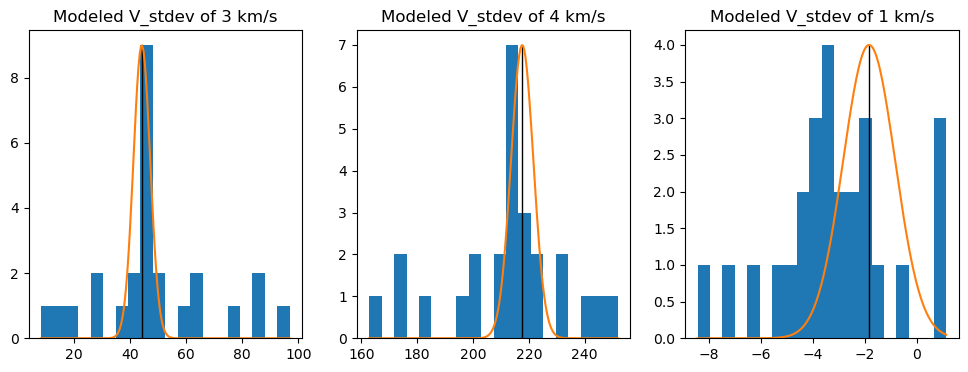

In [4]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
from scipy.stats import norm
import matplotlib.patches as patches


c = coord.SkyCoord(ra=ra, dec=dec, distance=dist, pm_ra_cosdec=pmra, pm_dec=pmdec, radial_velocity=rv, frame=coord.ICRS)
c_gc = c.transform_to(coord.Galactocentric)
print(c_gc.v_x)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(12,4)

def plot_vel_hist(v_data, v_ref, stdev_guess, ax):
    h, bins, _ = ax.hist(v_data, bins=20)
    ax.add_patch(patches.PathPatch(Path([(v_ref, 0),(v_ref, np.max(h))]), fill=False))
    ax.set_title(f"Modeled V_stdev of {stdev_guess} km/s")

    x = np.linspace(np.min(bins), np.max(bins), 200)
    y = norm(loc = v_ref, scale=stdev_guess).pdf(x)*np.sqrt(2*np.pi)*stdev_guess*np.max(h)
    ax.plot(x,y)

plot_vel_hist(member_galcoords.v_x, c_gc.v_x.value, stdev_guess=3, ax=ax1)
plot_vel_hist(member_galcoords.v_y, c_gc.v_y.value, stdev_guess=4, ax=ax2)
plot_vel_hist(member_galcoords.v_z, c_gc.v_z.value, stdev_guess=1, ax=ax3)

Setting up the double cluster I'm bringing in values from HW2: 7722 $M_\odot$ for my mass, and I'm pulling over my two critical radii in arc minutes to help model the self-potential of the double cluster. I'm using 3 km/s as the velocity dispersion because that seems somewhat reasonable from a very narrow interpretation of the plots, where I assume most of the data that appears to be an outlier above actually is. A quick Literature search reveals 1.5-2 km/s as a reasonable value, with a note that gaia's proper motion uncertainty is very near this value at the distance to the clusters.

I'm modeling the self gravity as two potentials, one for each of the clusters, using literature values for the two masses, and placing them in galactocentric coordinates about the mean position of the clusters.

In [5]:
import astropy.coordinates as coord
import numpy as np
import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic

from gala.dynamics import mockstream as ms

_ = coord.galactocentric_frame_defaults.set('v4.0')



doublecluster_dispersion = 3 * u.km/u.s
doublecluster_mass = 7722 * u.Msun

# Set up double cluster self- potential. critical radii taken from HW2
ngc869_rcrit = (result_table[0]['DISTANCE'] * u.pc * (3.036052498039207/60 * u.deg).to(u.rad))/u.rad
ngc884_rcrit = (result_table[1]['DISTANCE'] * u.pc * (4.088613050352847/60 * u.deg).to(u.rad))/u.rad

ngc869_c_gc = coord.SkyCoord(ra=result_table[0]['RA'] * u.deg, dec=result_table[0]['DEC'] * u.deg, distance=result_table[0]['DISTANCE']* u.pc, frame=coord.ICRS).transform_to(coord.Galactocentric)
ngc884_c_gc = coord.SkyCoord(ra=result_table[1]['RA'] * u.deg, dec=result_table[1]['DEC'] * u.deg, distance=result_table[1]['DISTANCE']*u.pc, frame=coord.ICRS).transform_to(coord.Galactocentric)

def compute_offset(pt, center):
    return [
        pt.x.to(u.kpc).value-center.x.to(u.kpc).value, 
        pt.y.to(u.kpc).value-center.y.to(u.kpc).value, 
        pt.z.to(u.kpc).value-center.z.to(u.kpc).value 
        ] * u.kpc

print(compute_offset(ngc869_c_gc, c_gc))
print(compute_offset(ngc884_c_gc, c_gc))
print([c_gc.x, c_gc.y, c_gc.z])

# These masses are literature values, together they are a bit more than my mass (5500 + 4300 = 9700)
ngc869_potential = gp.PlummerPotential(m=5500 * u.Msun , b = ngc869_rcrit, origin = compute_offset(ngc869_c_gc, c_gc), units=galactic)
ngc884_potential = gp.PlummerPotential(m=4300 * u.Msun , b = ngc884_rcrit, origin = compute_offset(ngc884_c_gc, c_gc), units=galactic)

doublecluster_potential = gp.CCompositePotential(component1 = ngc869_potential, component2 = ngc884_potential)
doublecluster_potential.replace_units(galactic)

# Set up initial conditions and stream generation
doublecluster_w0 = gd.PhaseSpacePosition(c_gc.cartesian)
df = ms.LagrangeCloudStreamDF(doublecluster_dispersion)



        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


[-0.06726157  0.07919536 -0.00966062] kpc
[ 0.06785811 -0.07867177  0.00940258] kpc
[<Quantity -9.59512055 kpc>, <Quantity 1.48111154 kpc>, <Quantity -0.10879543 kpc>]


Below is the actual simulation of the double cluster over 2.5 Gyr in the milky way potential. In this MWY potential it takes about 250Myr to complete an orbit, so the 10 plots below show the cluster slowly elongating to form a stream by orbit 2-3, and it becomes just part of the disk by orbits 8-10

odict_items([('disk', <MiyamotoNagaiPotential: m=6.80e+10, a=3.00, b=0.28 (kpc,Myr,solMass,rad)>), ('bulge', <HernquistPotential: m=5.00e+09, c=1.00 (kpc,Myr,solMass,rad)>), ('nucleus', <HernquistPotential: m=1.71e+09, c=0.07 (kpc,Myr,solMass,rad)>), ('halo', <NFWPotential: m=5.40e+11, r_s=15.62, a=1.00, b=1.00, c=1.00 (kpc,Myr,solMass,rad)>)])


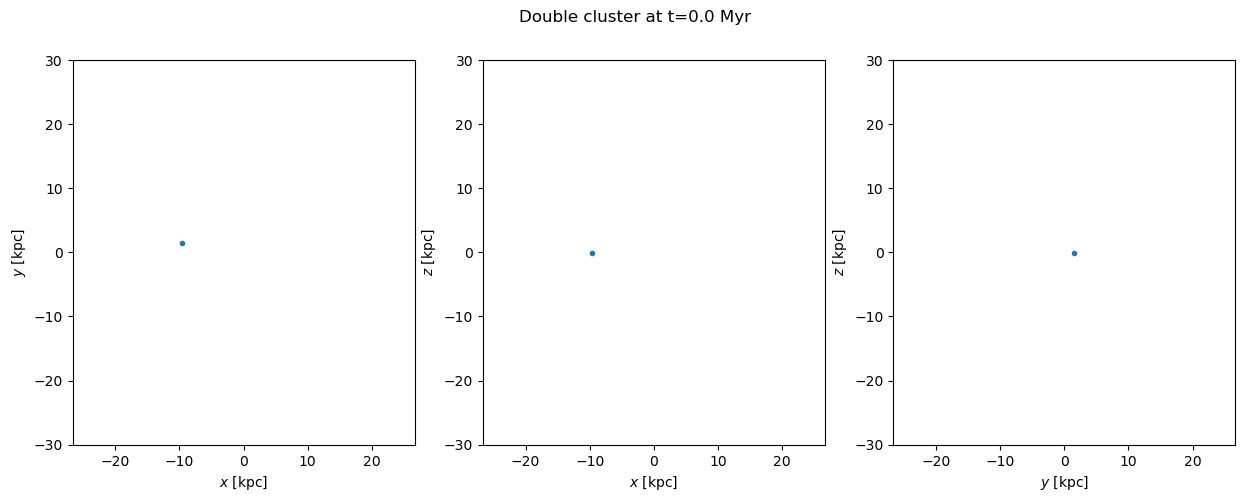

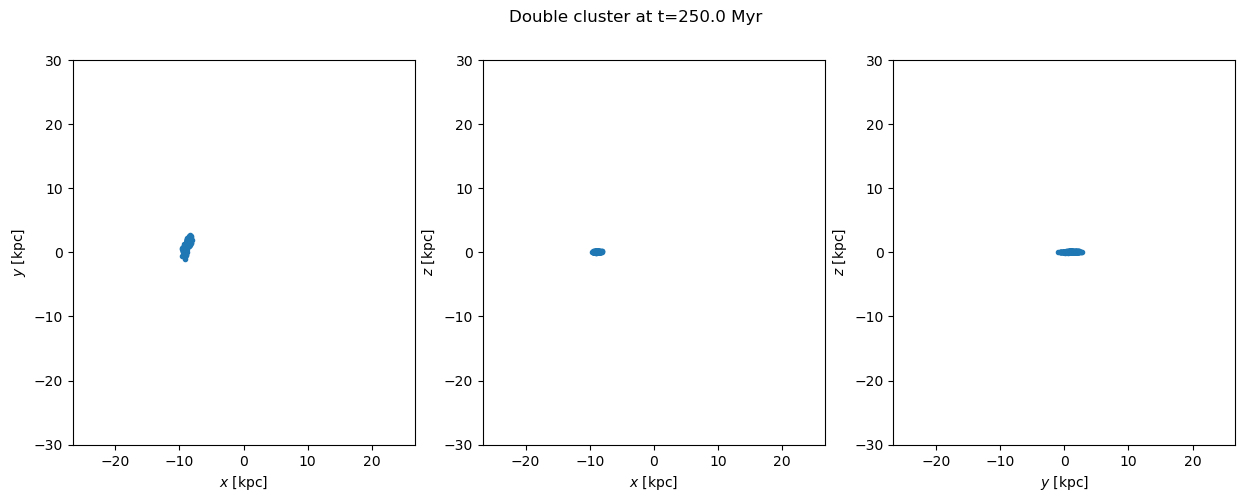

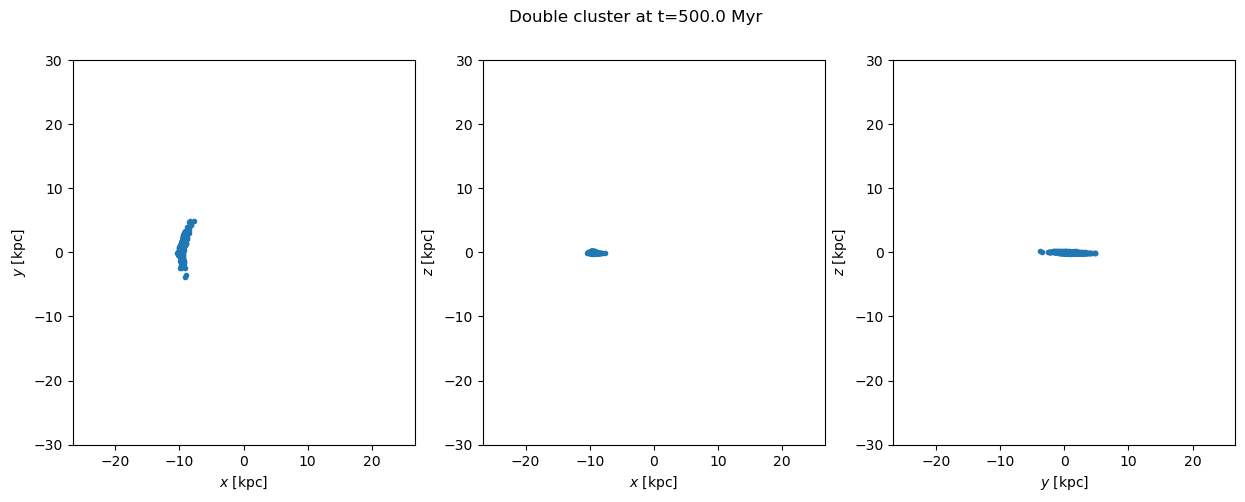

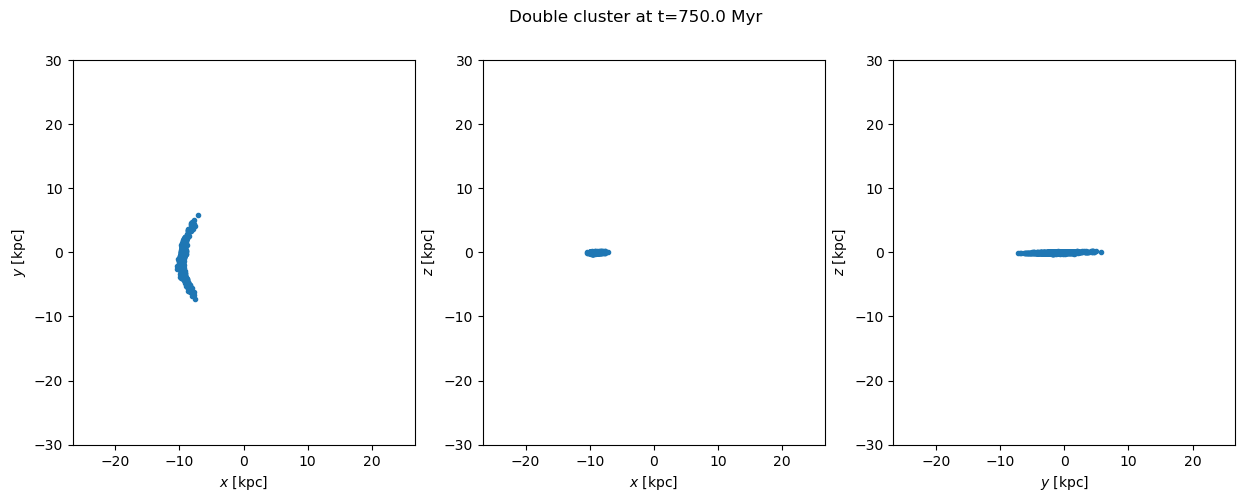

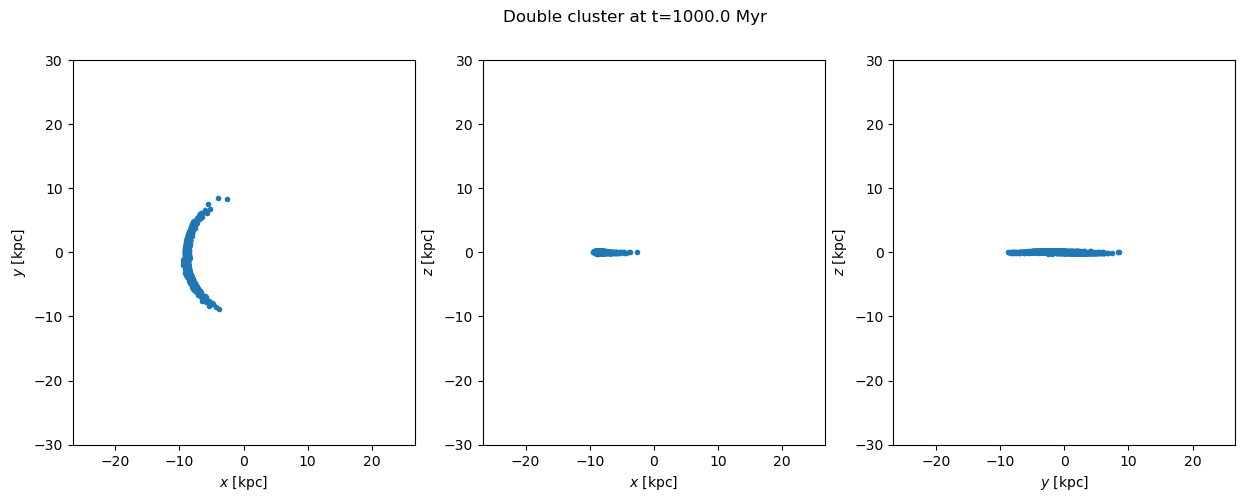

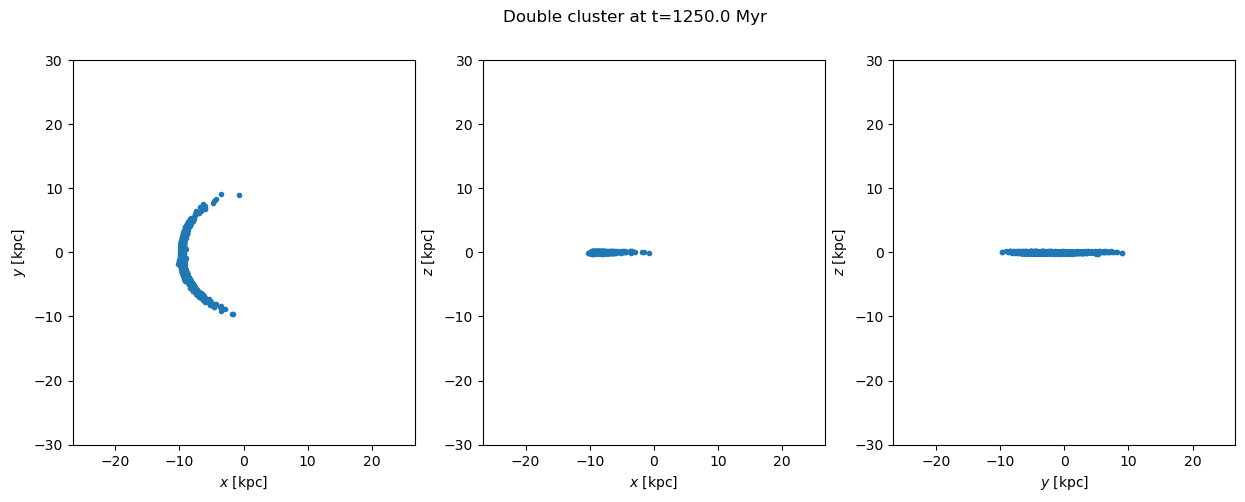

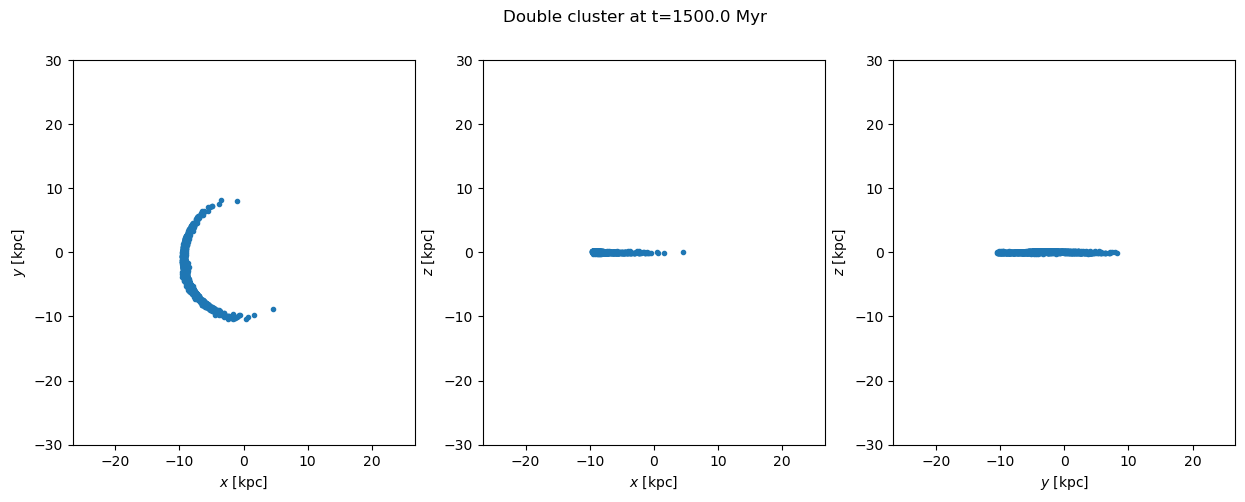

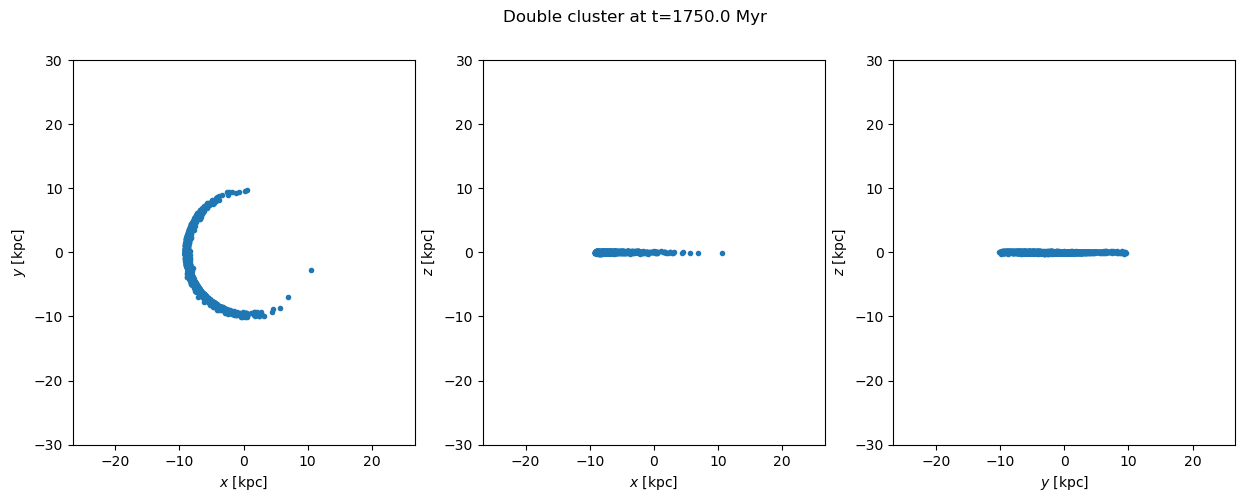

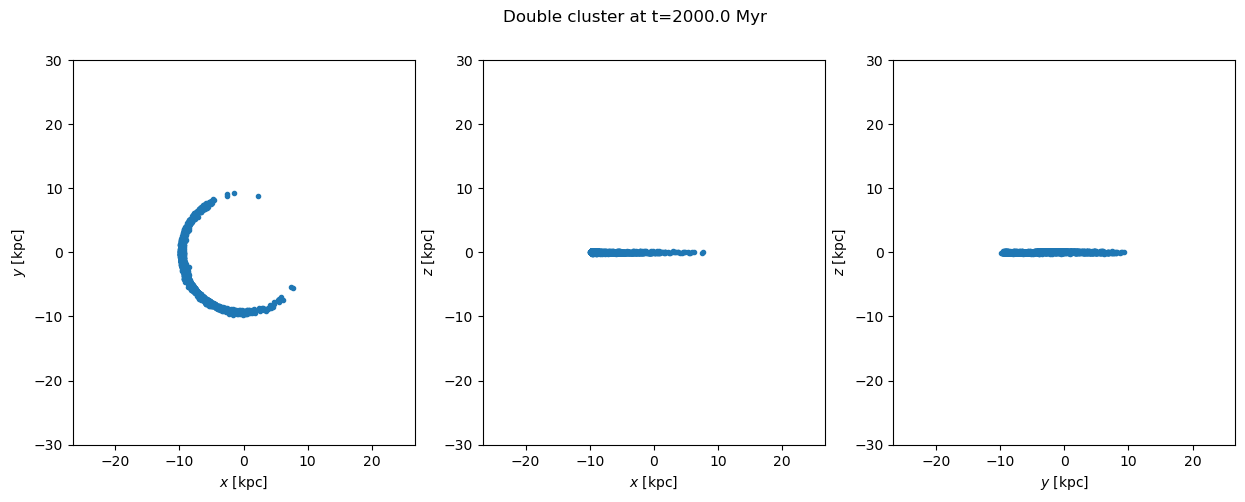

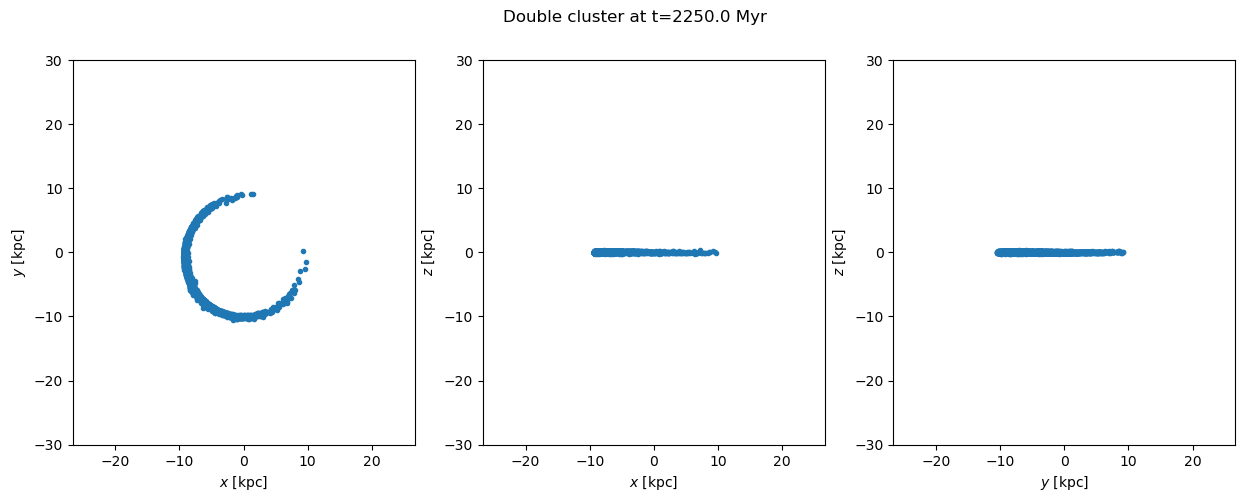

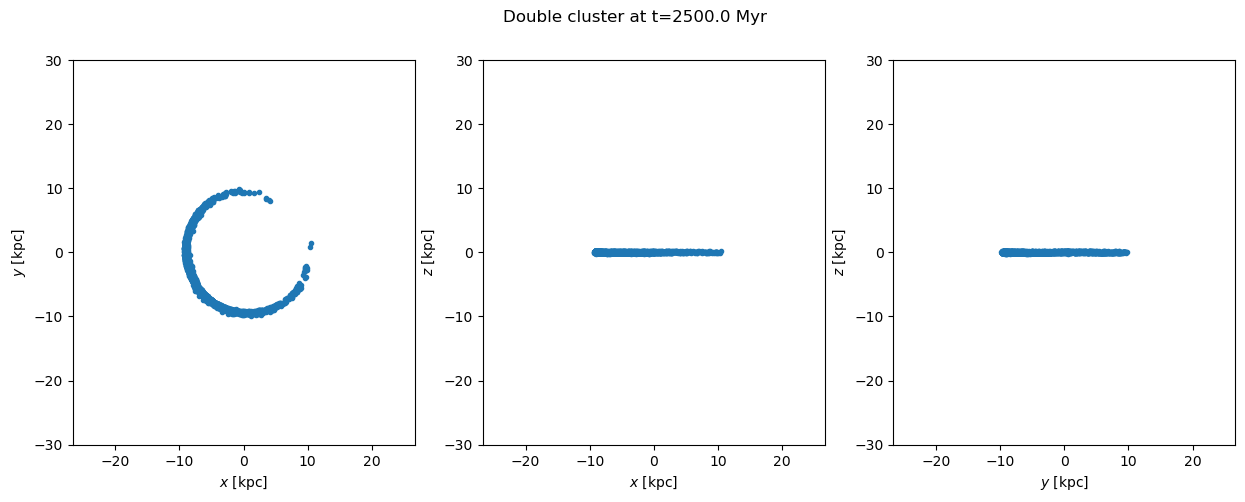

In [6]:
pot = gp.MilkyWayPotential()
print(pot.items())

gen_doublecluster = gd.MockStreamGenerator(df, pot, 
                                           progenitor_potential=doublecluster_potential
                                           )

sample_plots = 10
total_time = 2500*u.Myr
step_size = 1*u.Myr

def plot_snapshot(stream, time):
    fig, axes = plt.subplots(nrows=1, ncols=3) 
    fig.set_size_inches(15,5)
    fig.suptitle(f"Double cluster at t={time}")
    for ax in axes:
        ax.set_xlim((-30,30))
        ax.set_ylim((-30,30))
    stream.plot(axes = axes)


plot_snapshot(doublecluster_w0, 0*u.Myr)

for i in range(0,sample_plots):
    steps_per_plot = (total_time/(sample_plots*step_size)).to(u.dimensionless_unscaled)
    steps_this_plot = steps_per_plot*(i+1)

    doublecluster_stream, _ = gen_doublecluster.run(doublecluster_w0, doublecluster_mass, dt=step_size, n_steps=steps_this_plot)
    elapsed_time = steps_this_plot*step_size
    plot_snapshot(doublecluster_stream, elapsed_time)
    

## Part 2.2

By contrast, when the same situation is set up in an NFW potential, without the concentrated mass of the disk and nucleus a couple of weird things happen. First, an orbit takes closer to 600 Myr, and the resulting stream does not end up in a disk like pattern, it ends up further out and in a higher eccentricity configuration.

The first set of plots here shows the first orbit and how long it takes. The eccentricity of the stream also leads to a lengthening/contracting dynamic as the different components are in slightly different stages of their orbit.

{'_units': <UnitSystem (kpc, Myr, solMass, rad)>, 'parameters': {'m': <Quantity 5.4e+11 solMass>, 'r_s': <Quantity 15.62 kpc>, 'a': <Quantity 1.>, 'b': <Quantity 1.>, 'c': <Quantity 1.>}, 'G': 4.498502151469553e-12, 'origin': array([0., 0., 0.]), 'R': None, 'Wrapper': <class 'gala.potential.potential.builtin.cybuiltin.SphericalNFWWrapper'>, 'c_parameters': array([5.400e+11, 1.562e+01, 1.000e+00, 1.000e+00, 1.000e+00]), '_R': array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), 'c_instance': <gala.potential.potential.builtin.cybuiltin.SphericalNFWWrapper object at 0x0000028E2B863CE0>}


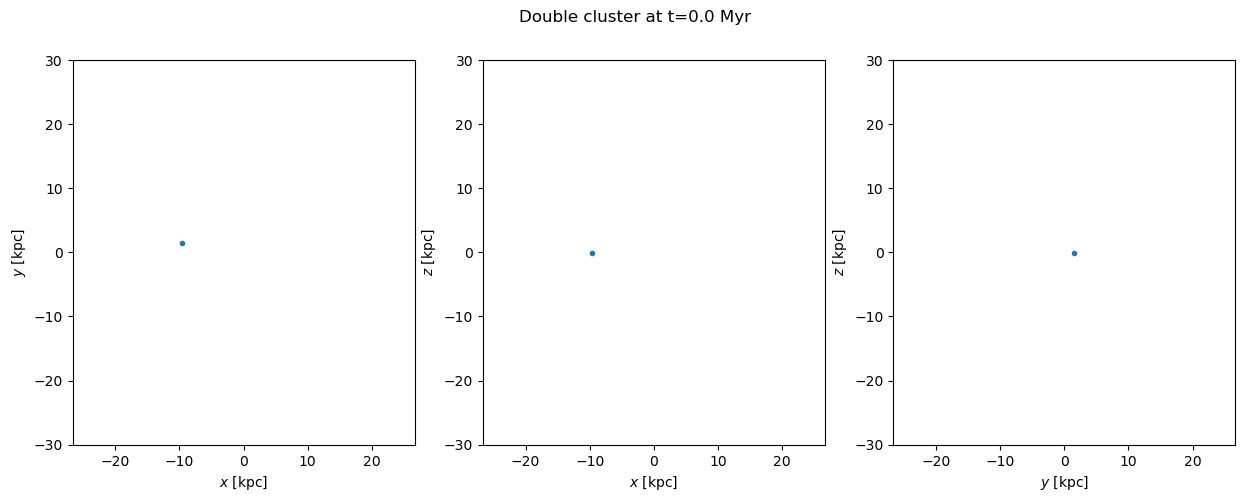

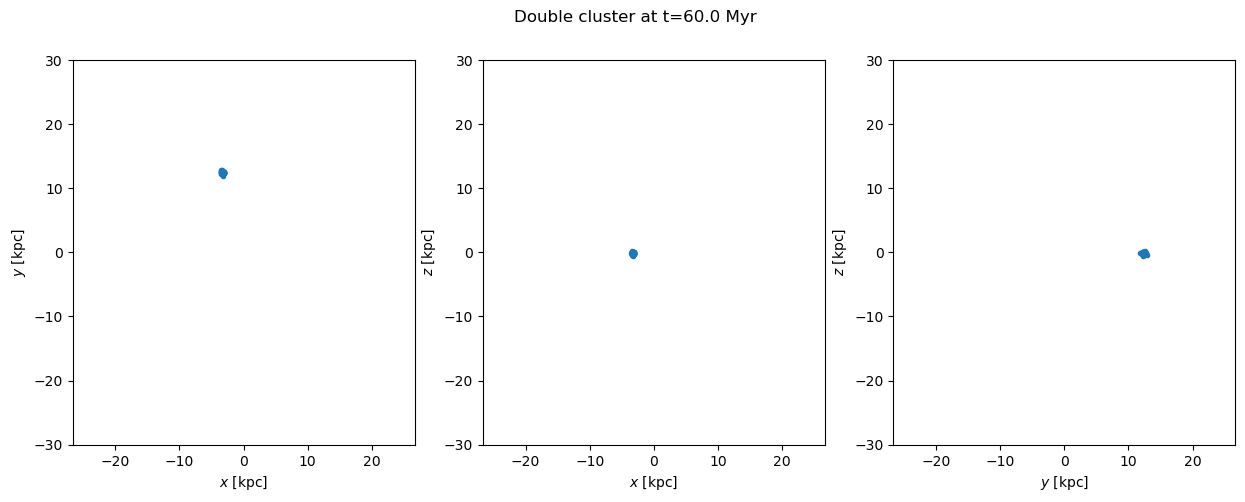

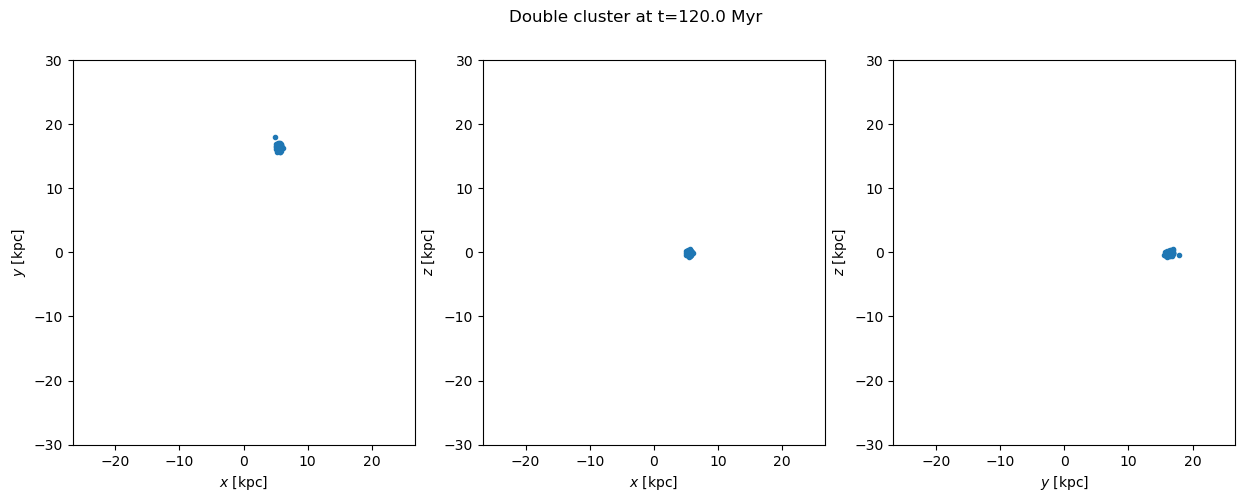

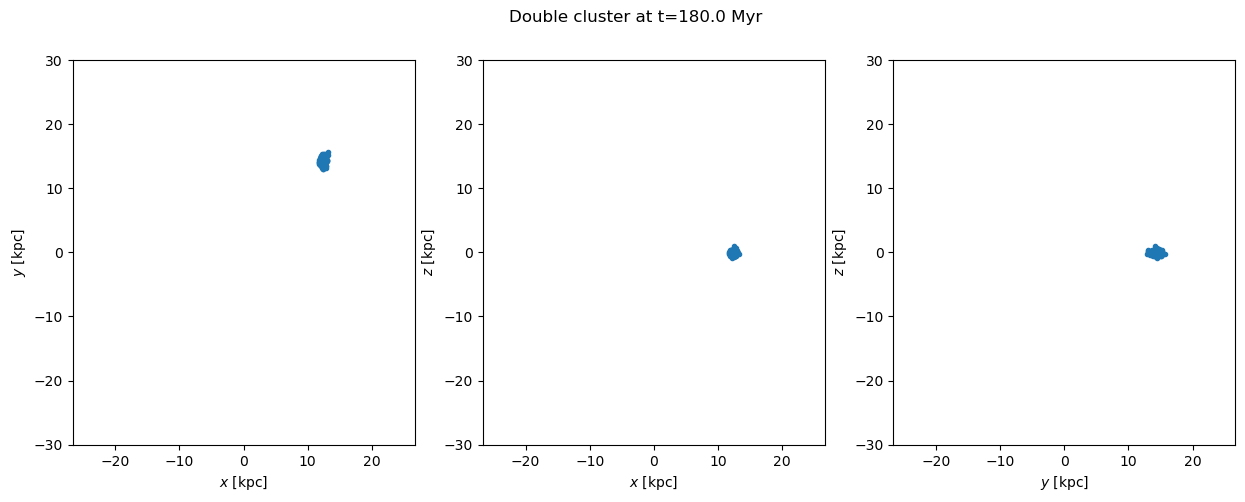

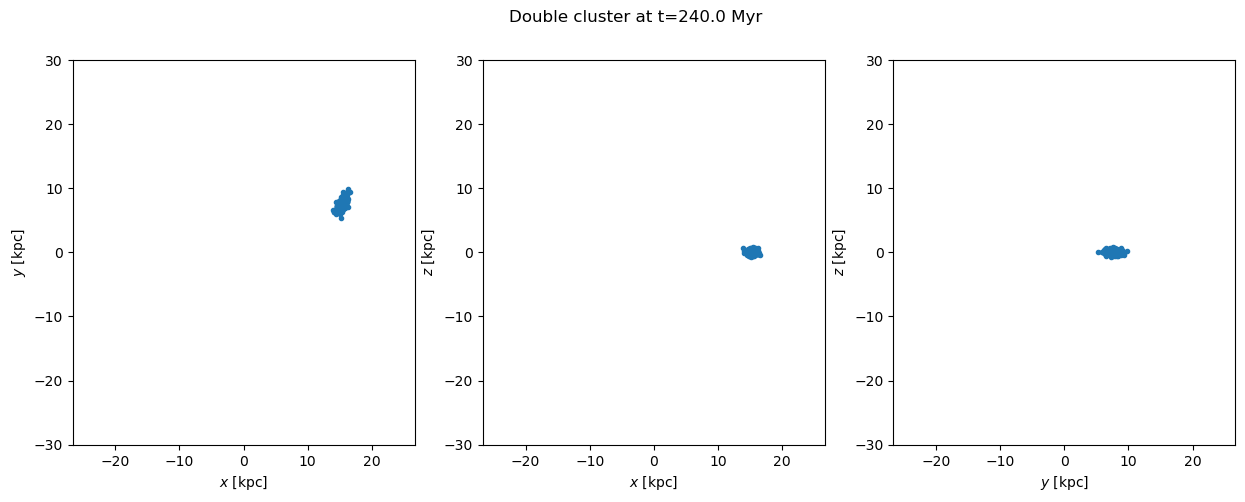

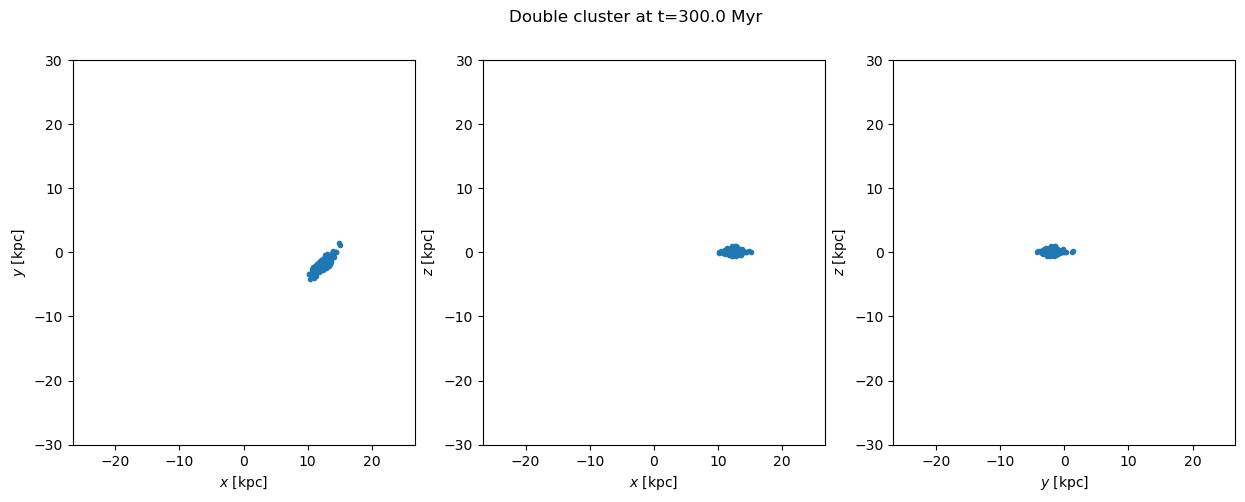

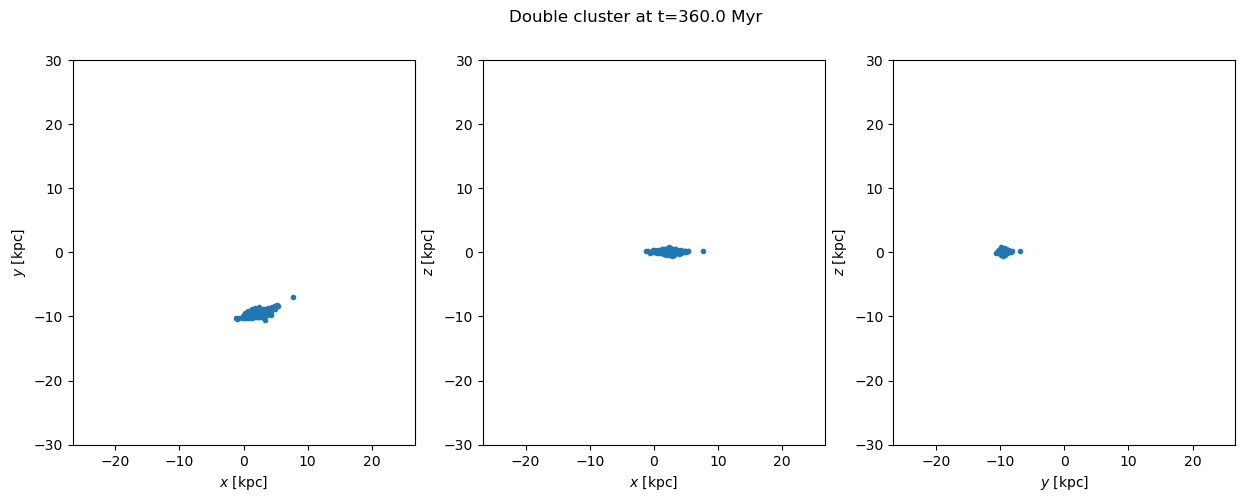

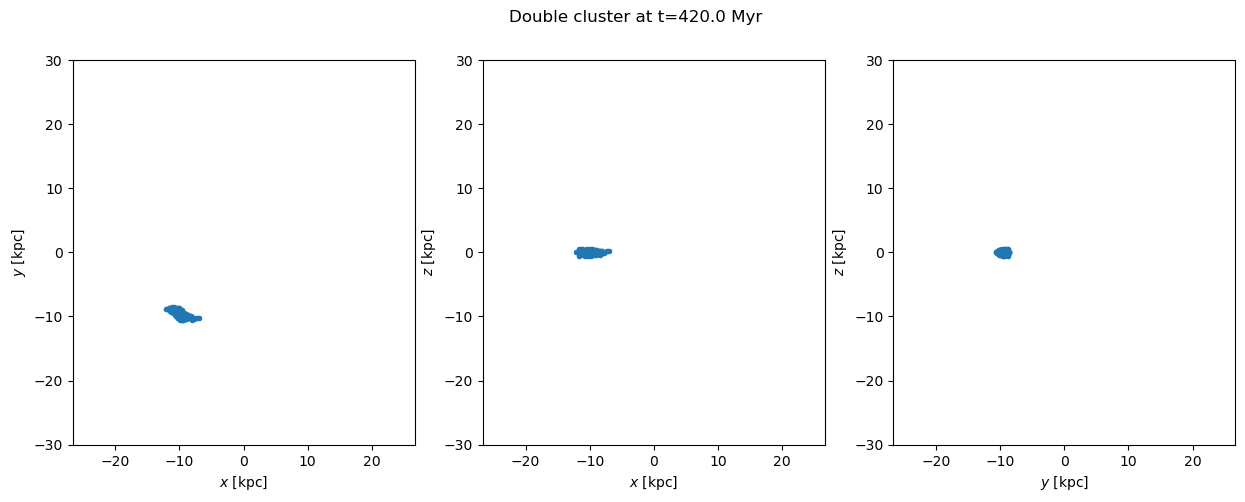

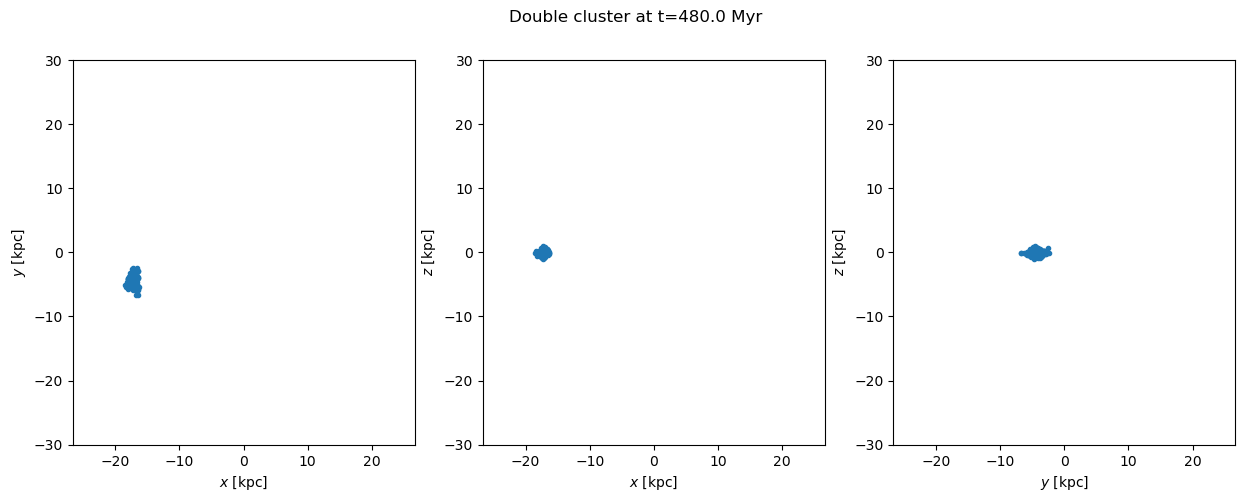

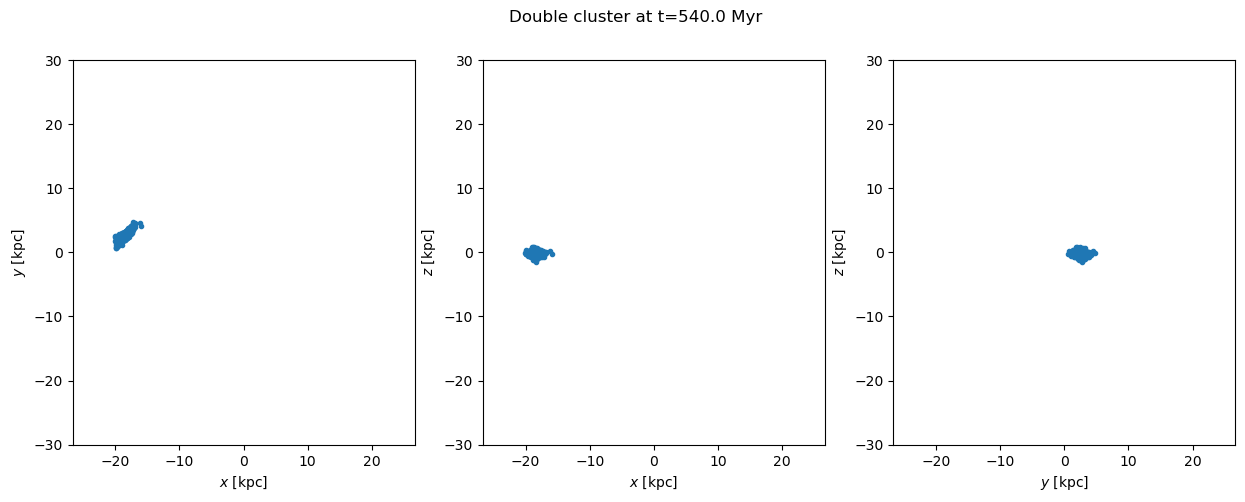

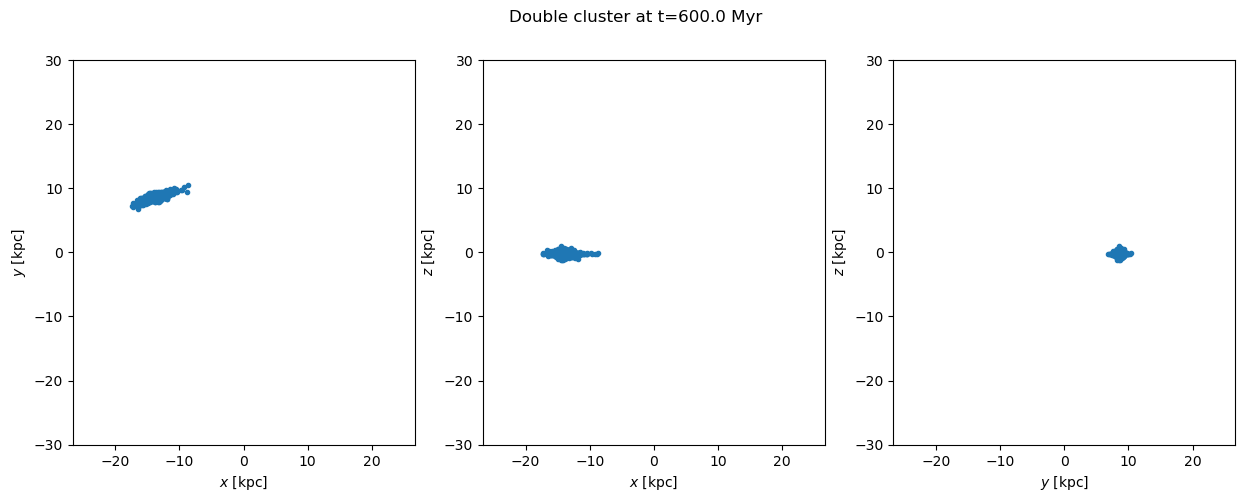

In [7]:
pot = gp.MilkyWayPotential()['halo']
print(pot.__dict__)

gen_doublecluster = gd.MockStreamGenerator(df, pot, 
                                           progenitor_potential=doublecluster_potential
                                           )

sample_plots = 10
total_time = 600*u.Myr
step_size = 1*u.Myr

def plot_snapshot(stream, time):
    fig, axes = plt.subplots(nrows=1, ncols=3) 
    fig.set_size_inches(15,5)
    fig.suptitle(f"Double cluster at t={time}")
    for ax in axes:
        ax.set_xlim((-30,30))
        ax.set_ylim((-30,30))
    stream.plot(axes = axes)


plot_snapshot(doublecluster_w0, 0*u.Myr)

for i in range(0,sample_plots):
    steps_per_plot = (total_time/(sample_plots*step_size)).to(u.dimensionless_unscaled)
    steps_this_plot = steps_per_plot*(i+1)

    doublecluster_stream, _ = gen_doublecluster.run(doublecluster_w0, doublecluster_mass, dt=step_size, n_steps=steps_this_plot)
    elapsed_time = steps_this_plot*step_size
    plot_snapshot(doublecluster_stream, elapsed_time)



This next group of plots shows approximately a single orbit per plot out to 6 Gyr. The inital conditions of the double cluster help keep it in the disk area, but you can see that the slower orbits in the NFW potential, and the effect of eccentricity, preserves it as more of a stream shape and less of a ring for quite a bit longer in time, but roughly the same number of orbits. By 8-10 orbits the double cluster is distributed all the way around the galaxy.

Looking closely at the Y-Z plots there is the hint of a wobble in the Z, which would contribute to the warp of the disk.

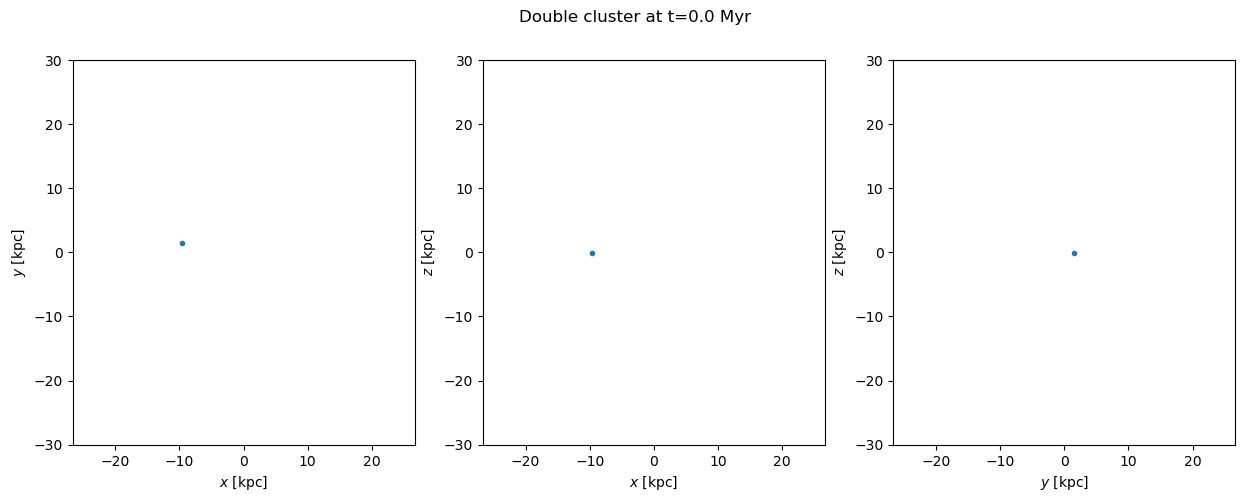

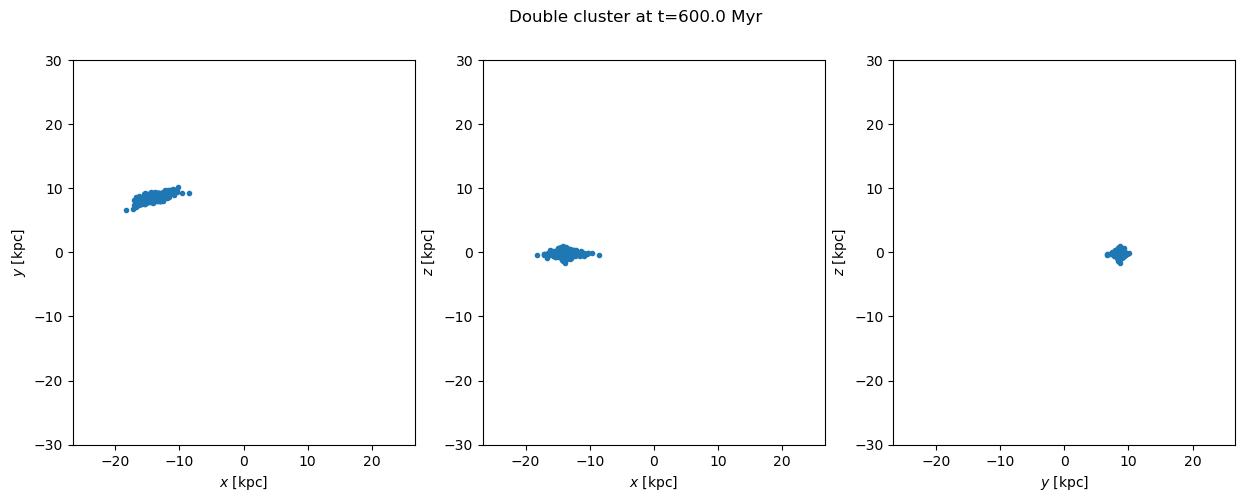

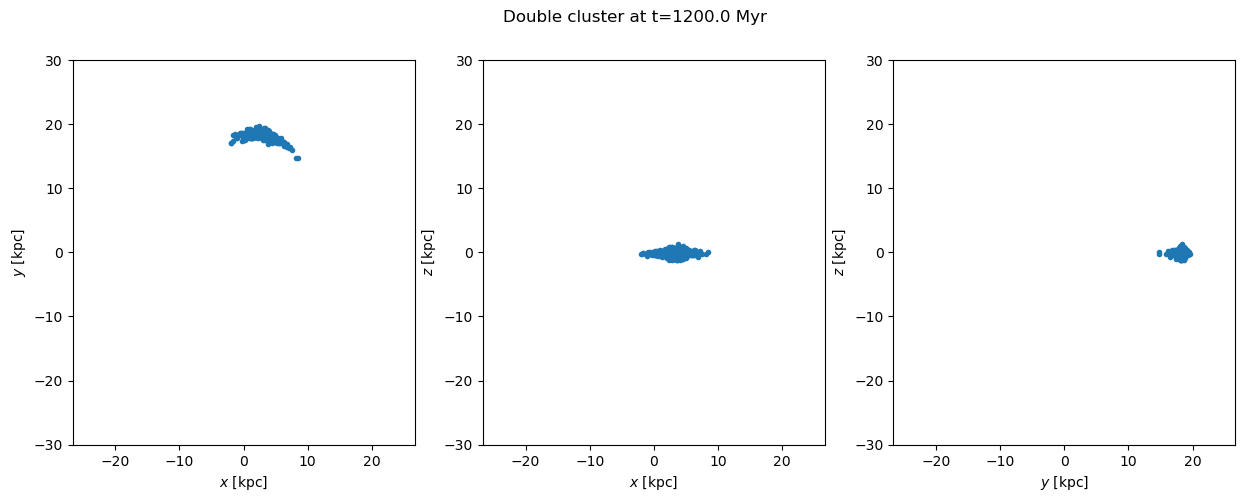

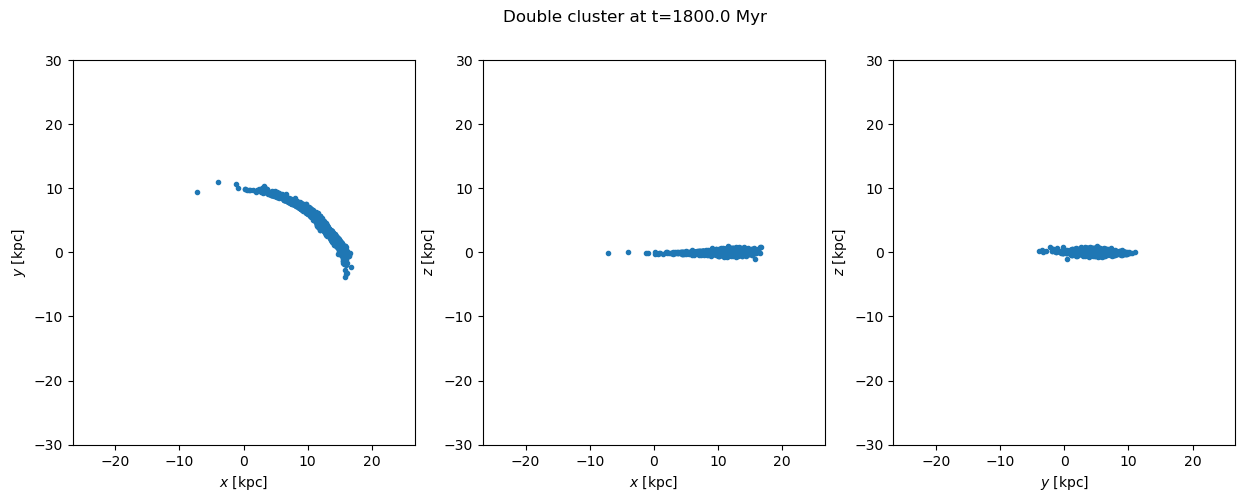

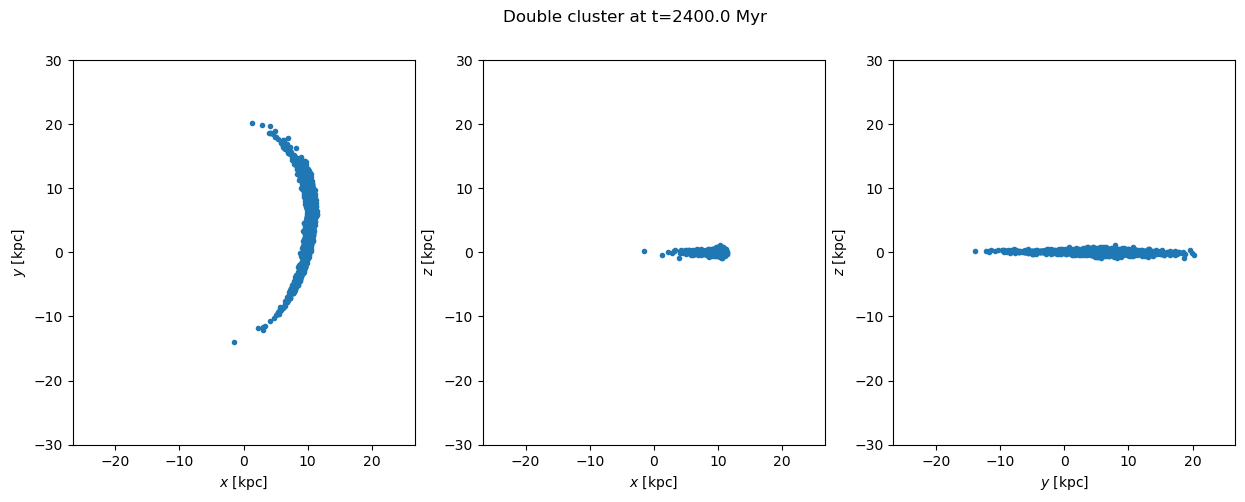

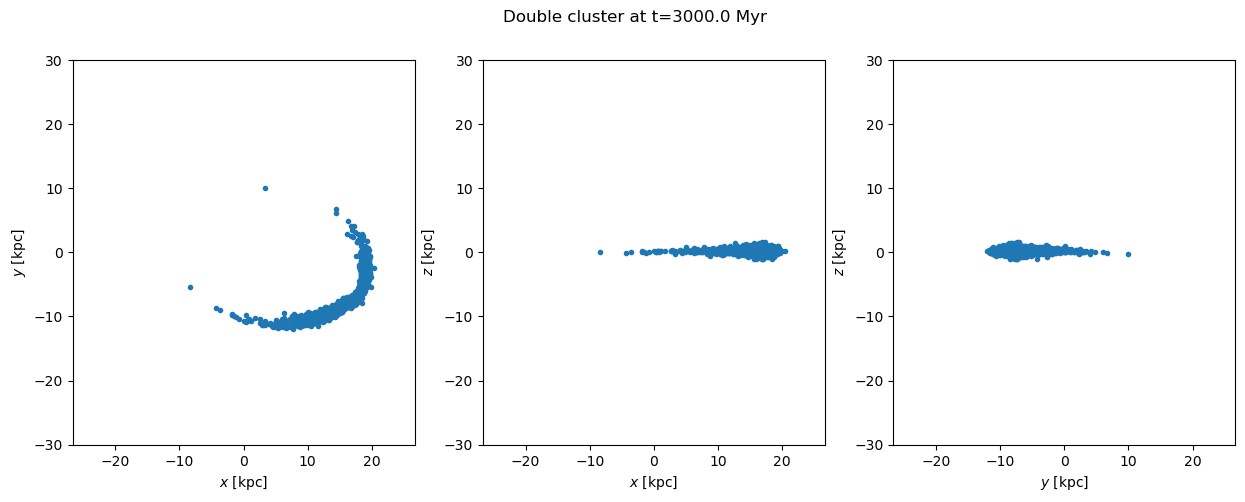

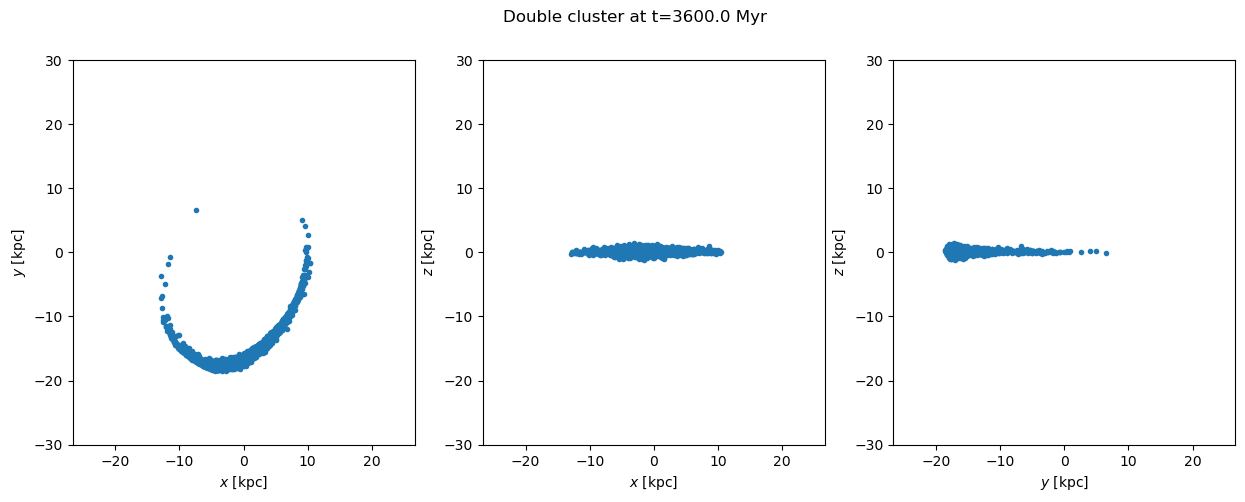

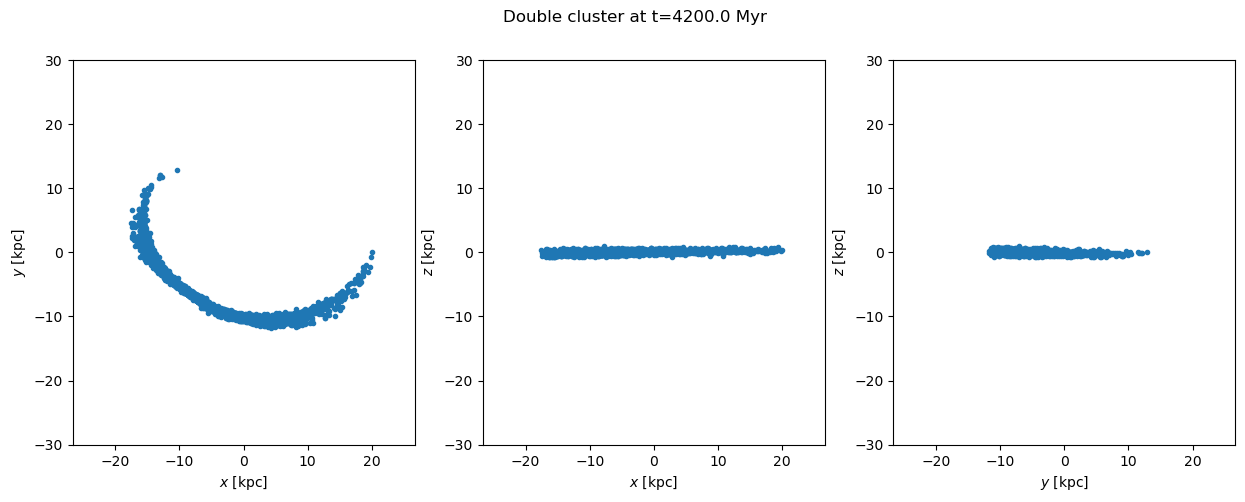

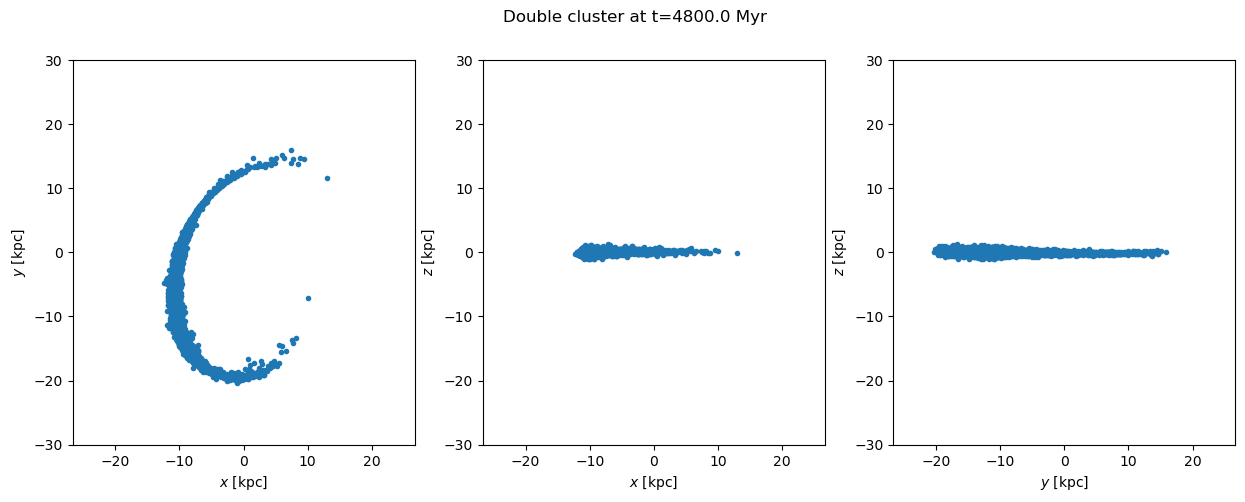

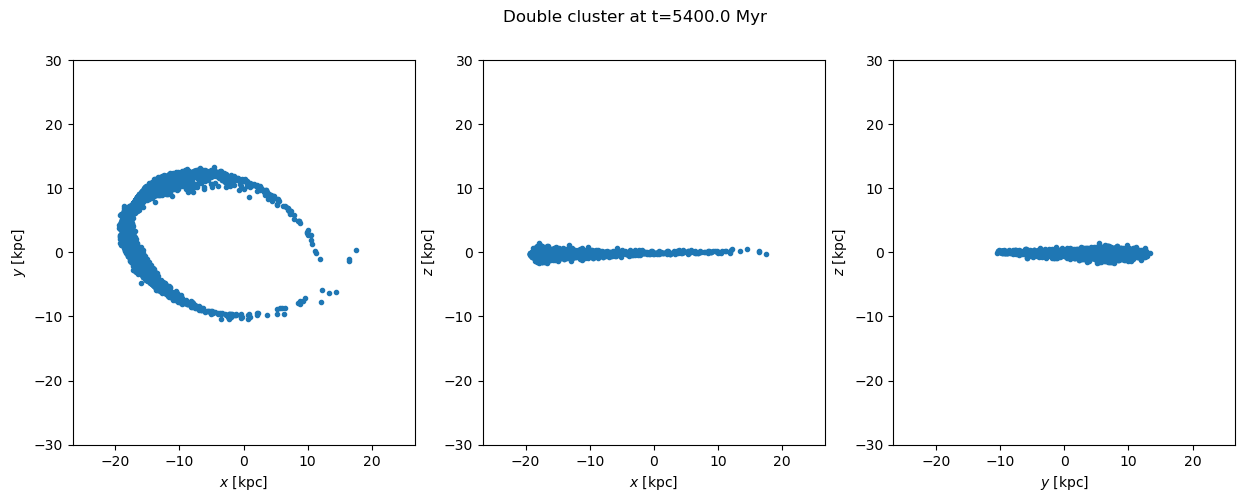

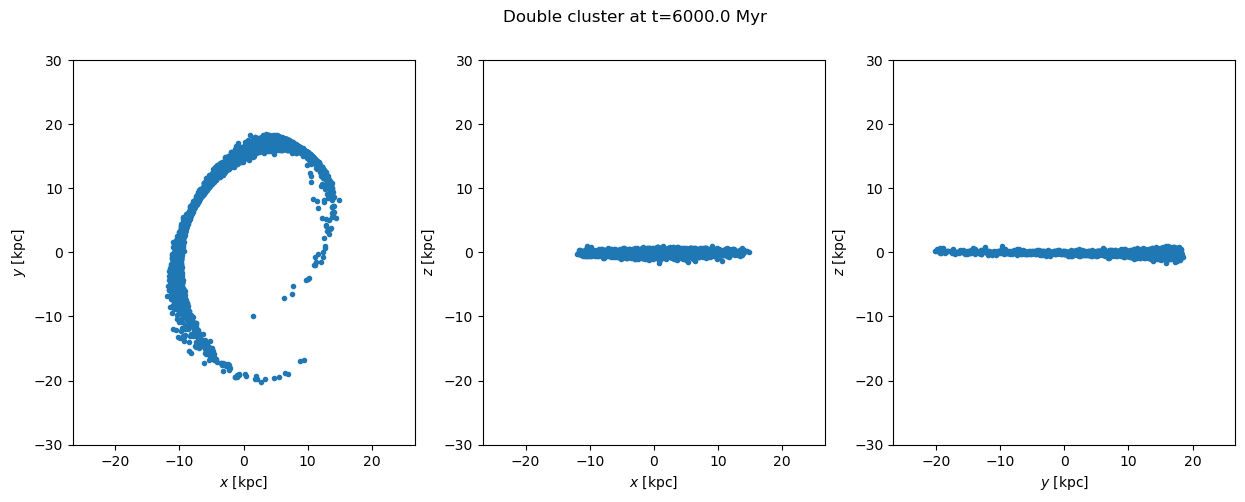

In [8]:
sample_plots = 10
total_time = 6000*u.Myr
step_size = 1*u.Myr

def plot_snapshot(stream, time):
    fig, axes = plt.subplots(nrows=1, ncols=3) 
    fig.set_size_inches(15,5)
    fig.suptitle(f"Double cluster at t={time}")
    for ax in axes:
        ax.set_xlim((-30,30))
        ax.set_ylim((-30,30))
    stream.plot(axes = axes)


plot_snapshot(doublecluster_w0, 0*u.Myr)

for i in range(0,sample_plots):
    steps_per_plot = (total_time/(sample_plots*step_size)).to(u.dimensionless_unscaled)
    steps_this_plot = steps_per_plot*(i+1)

    doublecluster_stream, _ = gen_doublecluster.run(doublecluster_w0, doublecluster_mass, dt=step_size, n_steps=steps_this_plot)
    elapsed_time = steps_this_plot*step_size
    plot_snapshot(doublecluster_stream, elapsed_time)

A final thing that stuck out to me while preparing these plots: In terms of determining when the stream formed, the self potential and velocity dispersion had a small effect in the beginning of the process, but the overall potential dominated during the stream phase. It was quite hard to create initial conditions where a stream *didn't* form.

Unfortunately we can't really watch the double cluster for even a few Myr to see what happens; however, it seems that most realistic situations have it breaking up quickly with respect to stellar lifetimes, and indeed at only 14Myr old it may already be starting to break up according to the literature.

Below is one attempt to keep the cluster together in an MWY potential. I've altered the dispersion to be 1/3 of its original value, and given the cluster about ~10x its true mass as self-gravity. As you can see, this slows up the destruction significantly; however, much lower values for velocity dispersion and higher gravity are needed to fully prevent destruction over the lifetimes of the stars in the cluster.

odict_items([('disk', <MiyamotoNagaiPotential: m=6.80e+10, a=3.00, b=0.28 (kpc,Myr,solMass,rad)>), ('bulge', <HernquistPotential: m=5.00e+09, c=1.00 (kpc,Myr,solMass,rad)>), ('nucleus', <HernquistPotential: m=1.71e+09, c=0.07 (kpc,Myr,solMass,rad)>), ('halo', <NFWPotential: m=5.40e+11, r_s=15.62, a=1.00, b=1.00, c=1.00 (kpc,Myr,solMass,rad)>)])


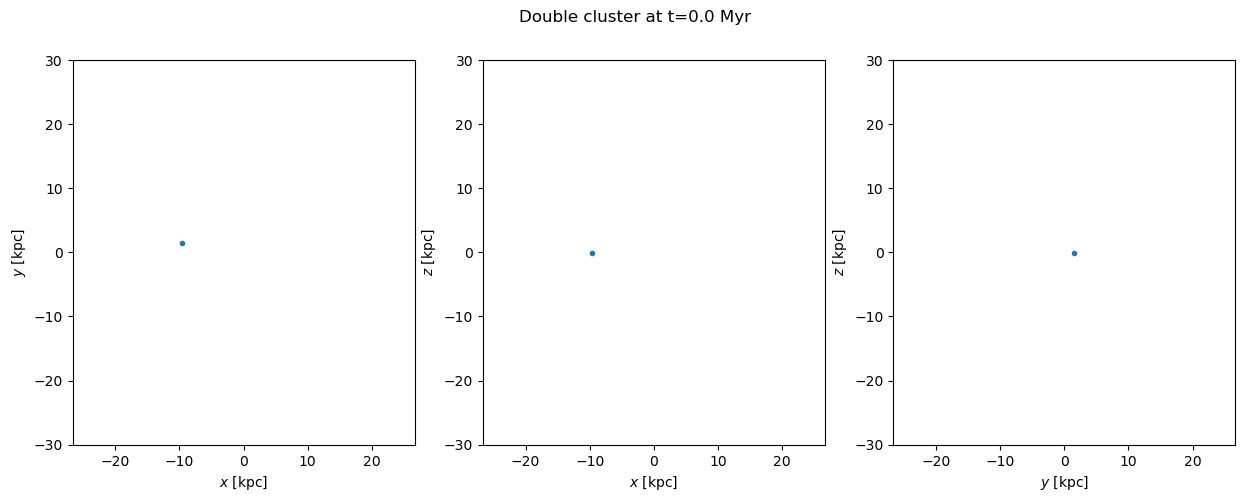

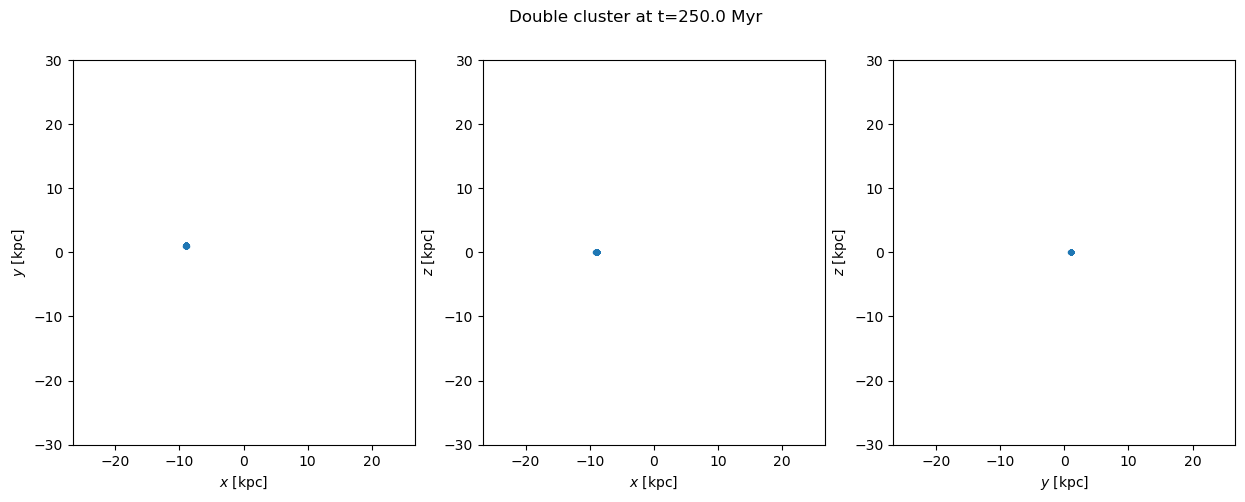

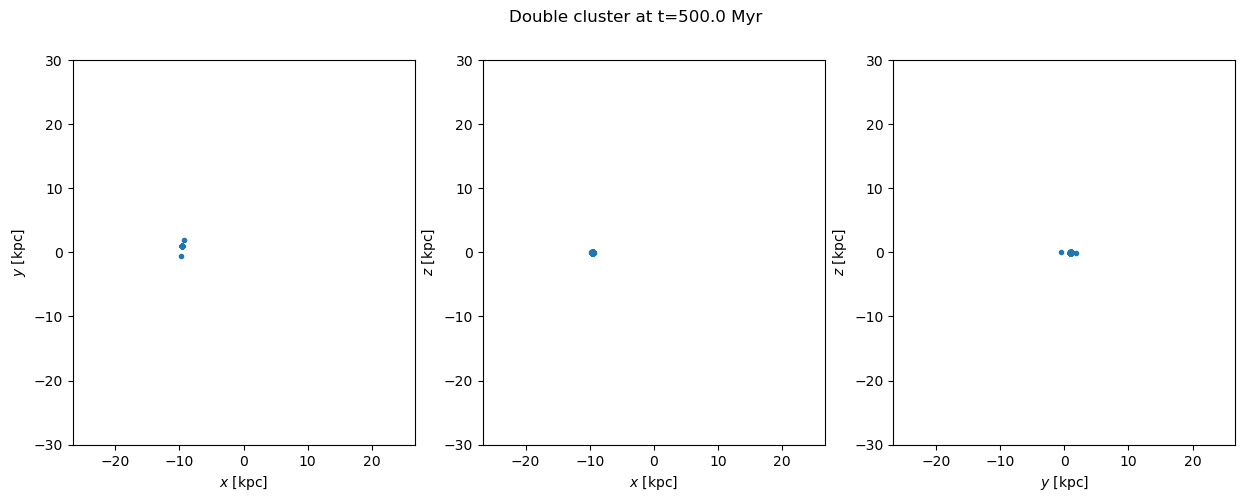

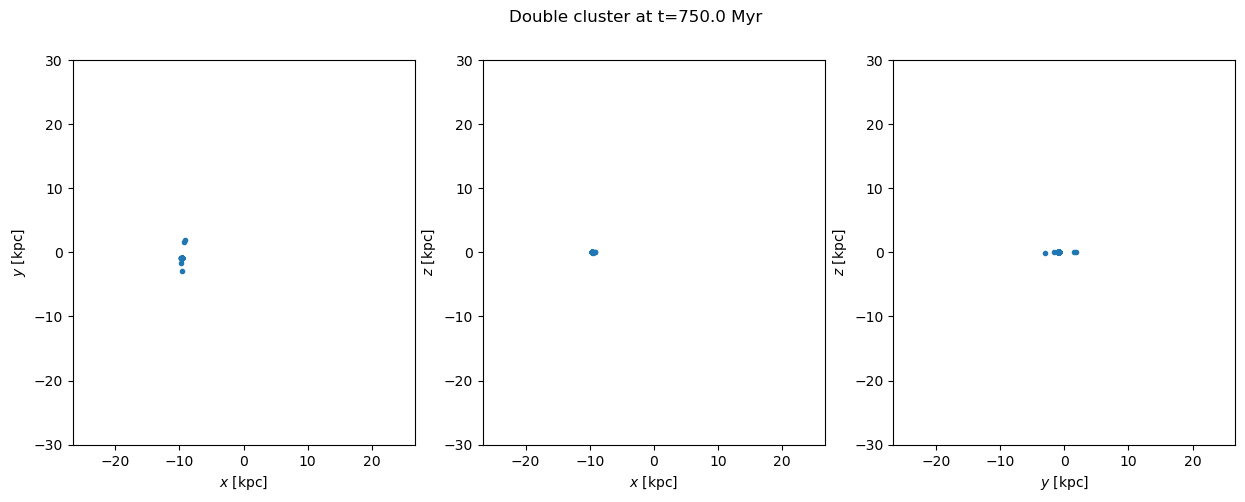

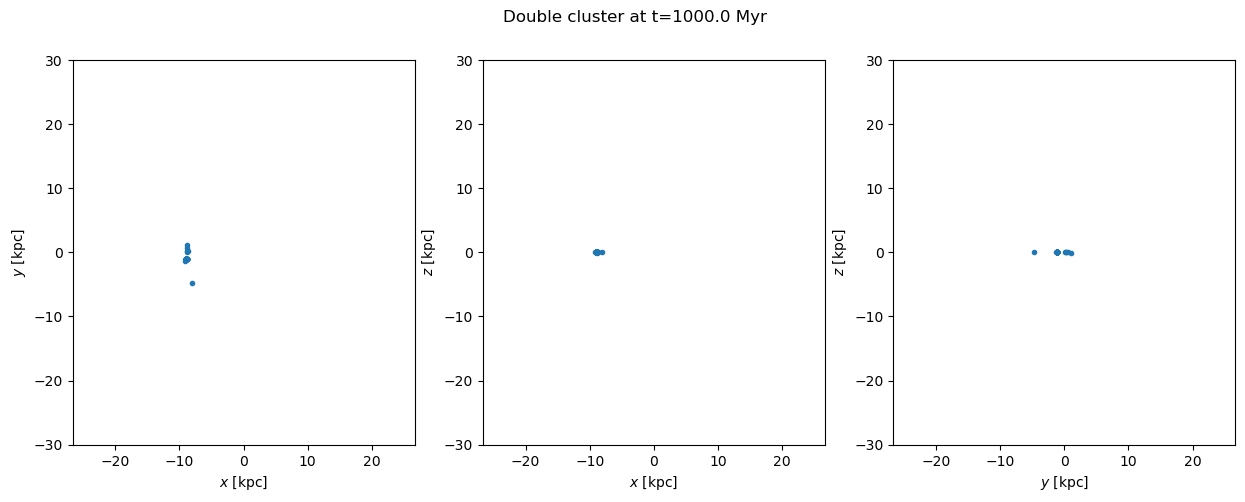

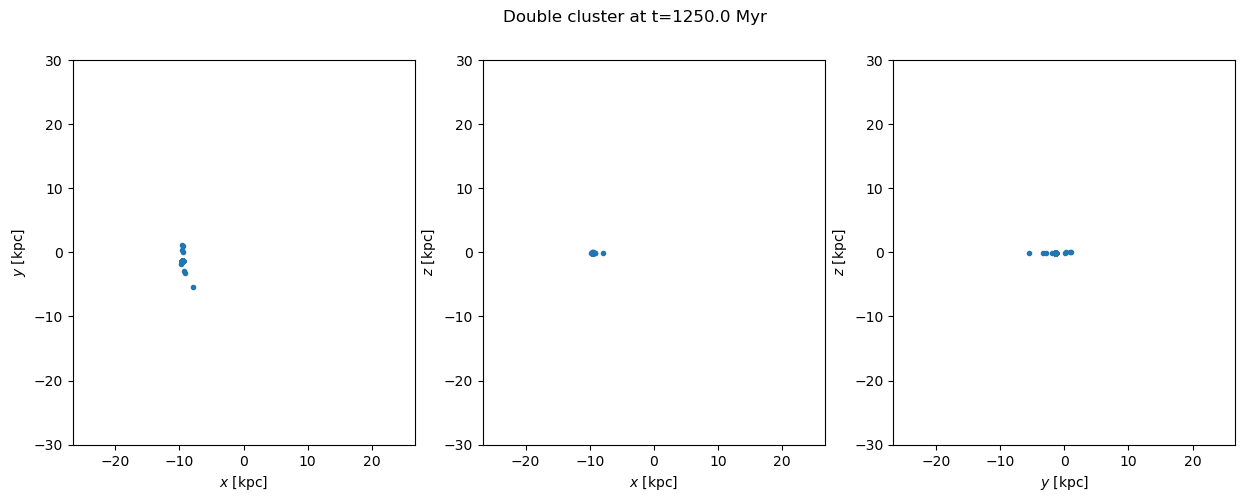

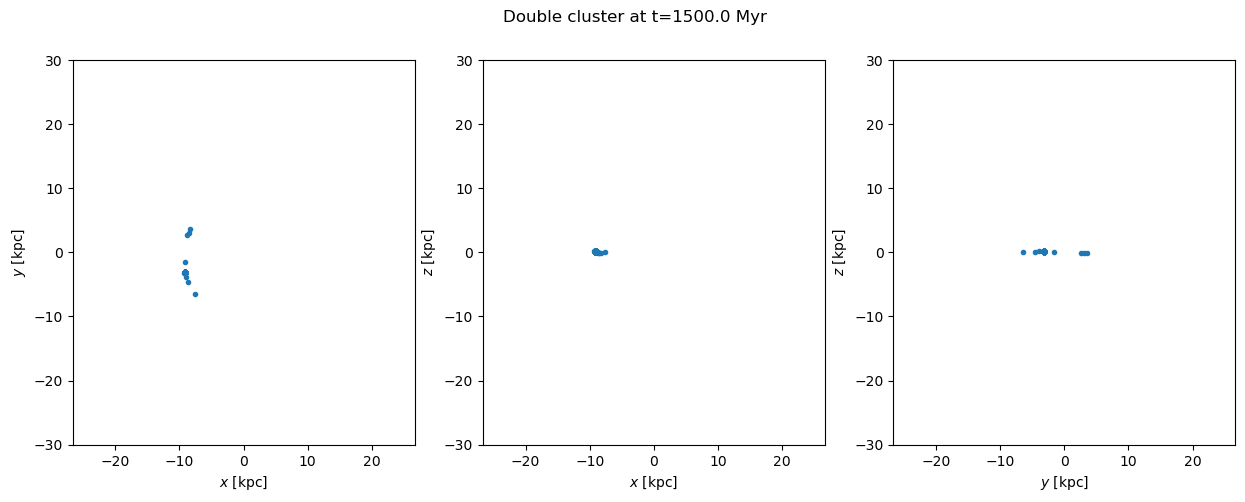

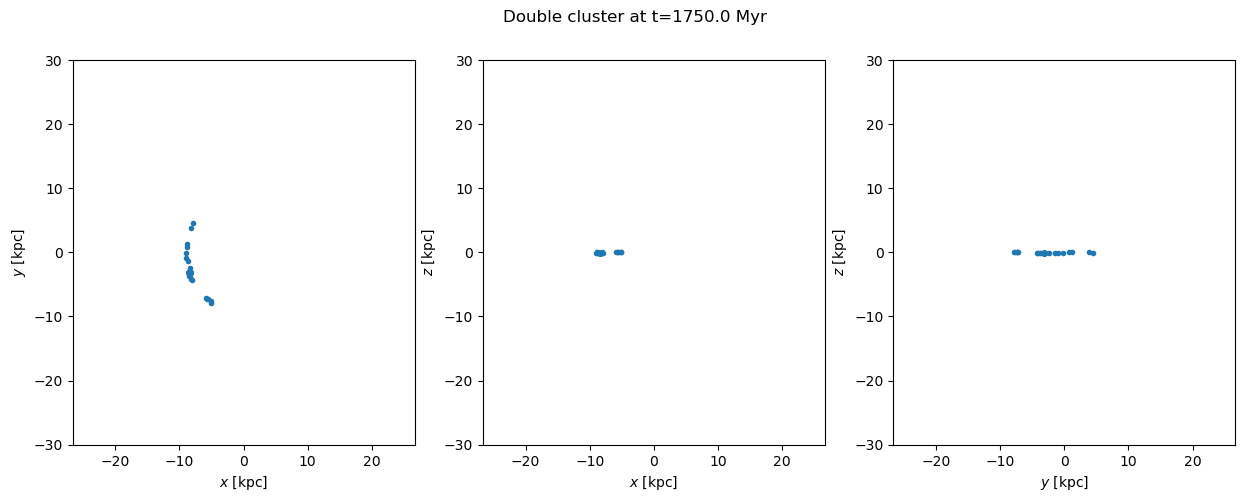

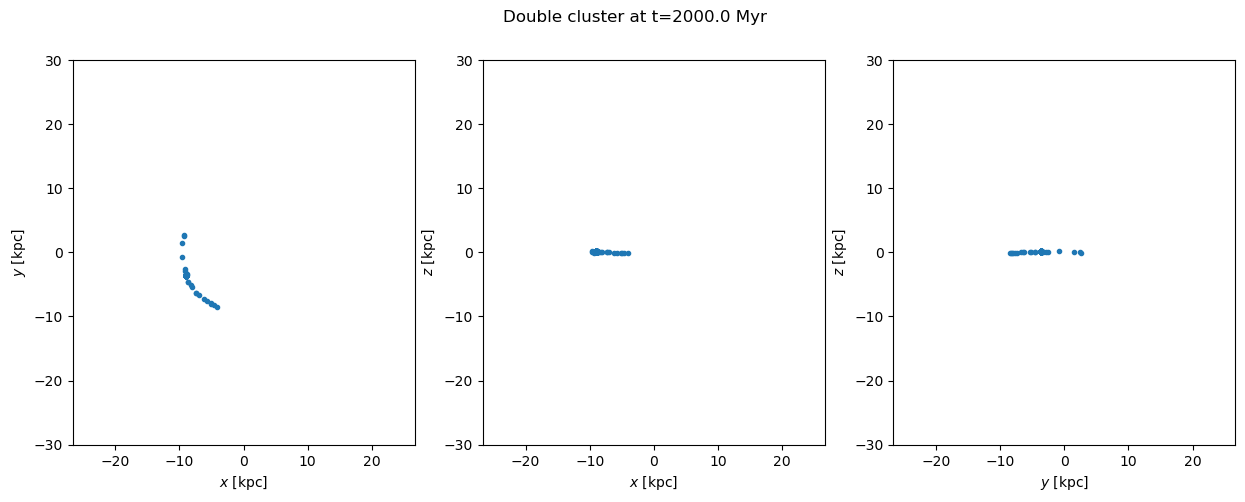

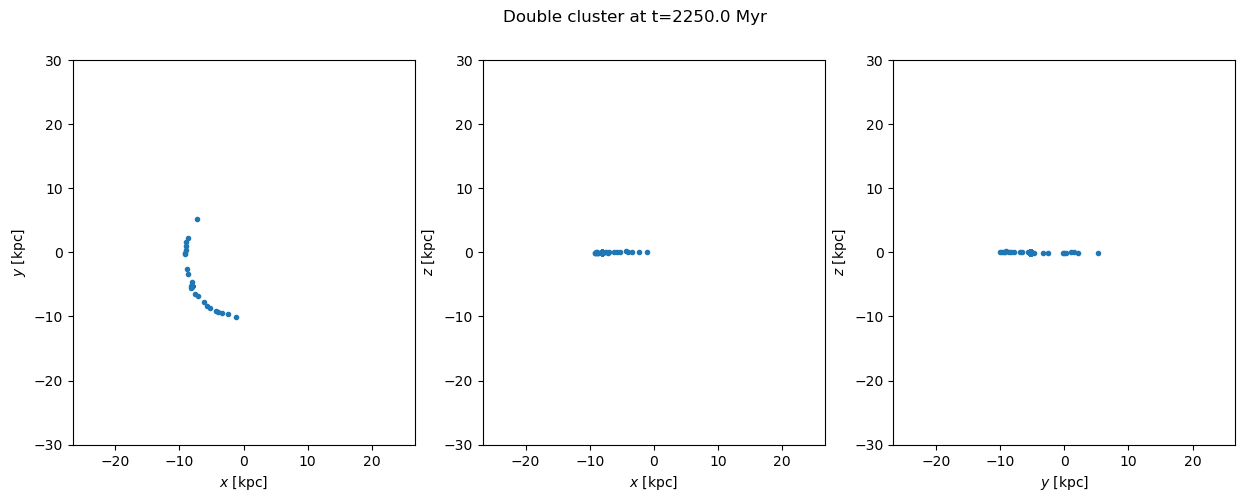

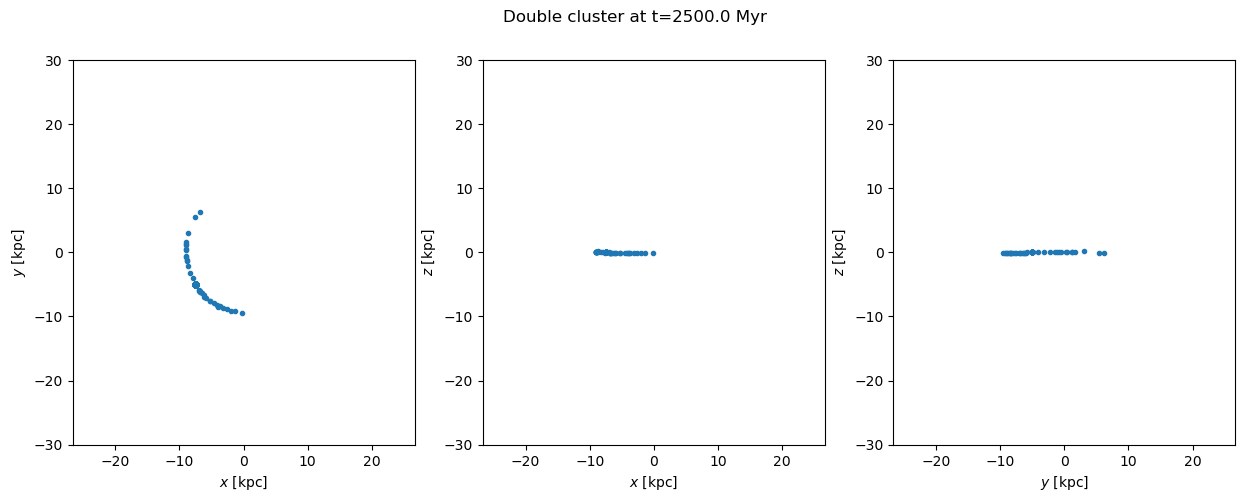

In [13]:
pot = gp.MilkyWayPotential()
print(pot.items())

df = ms.LagrangeCloudStreamDF( 1 * u.km/u.s)

gen_doublecluster = gd.MockStreamGenerator(df, pot, 
                                           progenitor_potential=gp.PlummerPotential(m=100_000 * u.Msun , b = 10*u.pc, units=galactic)
                                           )

sample_plots = 10
total_time = 2500*u.Myr
step_size = 1*u.Myr

def plot_snapshot(stream, time):
    fig, axes = plt.subplots(nrows=1, ncols=3) 
    fig.set_size_inches(15,5)
    fig.suptitle(f"Double cluster at t={time}")
    for ax in axes:
        ax.set_xlim((-30,30))
        ax.set_ylim((-30,30))
    stream.plot(axes = axes)


plot_snapshot(doublecluster_w0, 0*u.Myr)

for i in range(0,sample_plots):
    steps_per_plot = (total_time/(sample_plots*step_size)).to(u.dimensionless_unscaled)
    steps_this_plot = steps_per_plot*(i+1)

    doublecluster_stream, _ = gen_doublecluster.run(doublecluster_w0, doublecluster_mass, dt=step_size, n_steps=steps_this_plot)
    elapsed_time = steps_this_plot*step_size
    plot_snapshot(doublecluster_stream, elapsed_time)
    